In [1]:
import time

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import neighbors, svm, tree, linear_model, ensemble, neural_network, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score, cohen_kappa_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


In [2]:
%matplotlib inline

pd.set_option("max_columns",90, "max_rows", 90)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# read data
raw_df = pd.read_csv('Gse_panel_current_sample_raw.csv')

In [4]:
# handle the missing data[hold on]
df = raw_df.dropna(how='any').copy()

# convert target variable to binary
df['status'] = df['status'].apply(lambda x: int(x=='D60-D90'))

# remove unnecessary features, correlated features and ones that have no contribution to prediction
X = df.drop(['loan_id', 'status', 'status_prev'], axis=1).copy()
X.drop(['prop_state', 'oltv', 'oyr', 'orig_rt', 'orig_upb', 'avg_upb', 'year'], axis=1, inplace=True)
#X.drop(['loan_purp', 'fhb_flag', 'occ_stat', 'prop_type'], axis=1, inplace=True)

# perform log transformation for the highly skewed features
X_num = X.select_dtypes(include=['float64', 'int64'])
skewed_feat = X_num.skew()
skewed_idx = skewed_feat[skewed_feat.abs() > 1].index
X[skewed_idx] = X[skewed_idx].transform(np.log)

# feature engineering
# HPI - HPI_o
# PMMS - pmms_o


# convert the categorical vars to binary vars
X = pd.get_dummies(X)

y = df['status'].copy()

# split the sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Single and Ensemble Model

### Logistic Regression

Accuracy = 0.6135405466583668
0    0.997966
1    0.002034
Name: status, dtype: float64


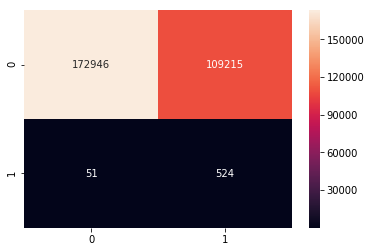

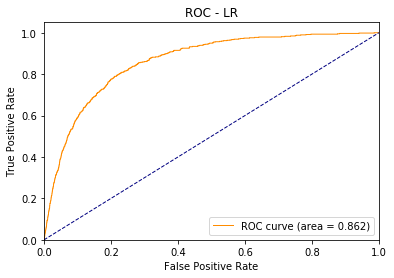

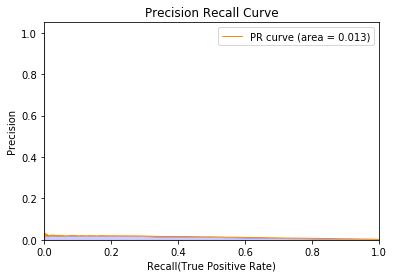

0.005476113864845589


In [11]:
linear_lr = linear_model.LogisticRegression(class_weight = {1: 1000})
linear_lr.fit(X_train, y_train)
y_pred = linear_lr.predict(X_test)

# accuracy score
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")

# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

# counts of 0-1 in the test sample set
print(y_test.value_counts(normalize=True))


# ROC - AUC  
conf_score = linear_lr.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
fpr, tpr, _ = roc_curve(y_test, conf_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - LR')
plt.legend(loc="lower right")
plt.show()

# PR AUC  
conf_score = linear_lr.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
precision, recall, _ = precision_recall_curve(y_test, conf_score)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.3f)' % average_precision_score(y_test, conf_score))
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="upper right")
plt.show()

# cohen's kappa: how well the classifier performed as compared to how well it would have performed simply by chance
print(cohen_kappa_score(y_test, y_pred))

### AdaBoost

Accuracy = 0.5976458604493238
0    0.997966
1    0.002034
Name: status, dtype: float64


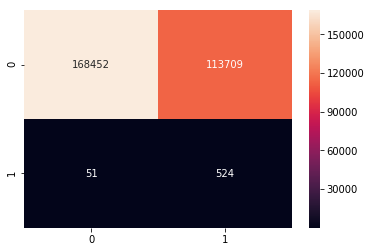

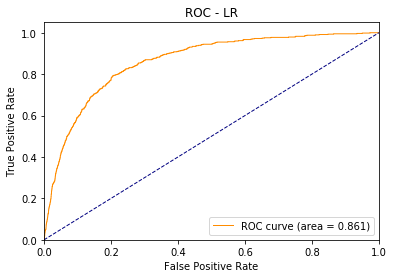

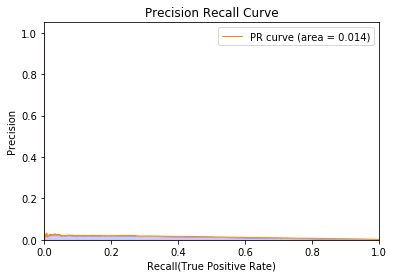

In [12]:
adb = AdaBoostClassifier(linear_model.LogisticRegression(class_weight = {1: 1000}))
adb.fit(X_train, y_train)
y_pred = adb.predict(X_test)

# accuracy score
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")

# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

# counts of 0-1 in the test sample set
print(y_test.value_counts(normalize=True))

# ROC and AUC  
conf_score = adb.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
fpr, tpr, _ = roc_curve(y_test, conf_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - LR')
plt.legend(loc="lower right")
plt.show()

# PR AUC  
conf_score = adb.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
precision, recall, _ = precision_recall_curve(y_test, conf_score)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.3f)' % average_precision_score(y_test, conf_score))
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="upper right")
plt.show()

### GradientBoost

Accuracy = 0.9979663007186916
0    0.997966
1    0.002034
Name: status, dtype: float64


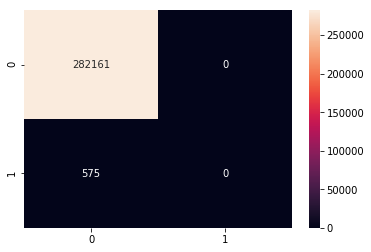

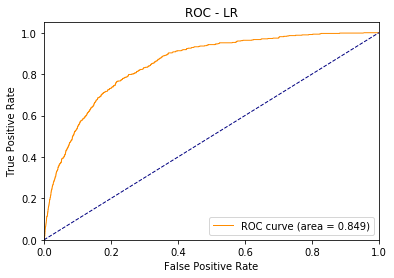

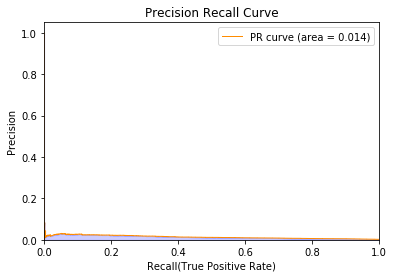

In [80]:
gb = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=40, 
                                 subsample=0.75, min_samples_split=800, min_samples_leaf=50,
                                 max_depth=4, max_features=19, random_state=0, verbose=0)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

# accuracy score
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")

# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

# counts of 0-1 in the test sample set
print(y_test.value_counts(normalize=True))

# ROC and AUC  
conf_score = gb.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
fpr, tpr, _ = roc_curve(y_test, conf_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - LR')
plt.legend(loc="lower right")
plt.show()

# PR AUC  
conf_score = gb.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
precision, recall, _ = precision_recall_curve(y_test, conf_score)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.3f)' % average_precision_score(y_test, conf_score))
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="upper right")
plt.show()

### XGBoost

In [14]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

### SVM

In [ ]:
clf_svm = svm.SVC(class_weight={1: 10})
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)


In [ ]:
# accuracy score
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")

# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

# counts of 0-1 in the test sample set
print(y_test.value_counts(normalize=True))

# ROC and AUC  
conf_score = clf_svm.decision_function(X_test)    # print(roc_auc_score(y_test, conf_score))    
fpr, tpr, _ = roc_curve(y_test, conf_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - LR')
plt.legend(loc="lower right")
plt.show()

# PR AUC  
precision, recall, _ = precision_recall_curve(y_test, conf_score)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.3f)' % average_precision_score(y_test, conf_score))
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="upper right")
plt.show()

## Stacking Models